T5_3

## Import packages

In [1]:
!nvidia-smi

Fri Sep  3 14:06:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 7.1 MB/s 
     |████████████████████████████████| 376 kB 52.4 MB/s 
     |████████████████████████████████| 45 kB 4.1 MB/s 


In [3]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from stellargraph import StellarGraph
import pandas as pd
import numpy as np
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph
from stellargraph import datasets
from sklearn import model_selection
from IPython.display import display, HTML
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten,  BatchNormalization
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [5]:
root_path = 'https://raw.githubusercontent.com/soeai/MAppGraph/gh-pages/data'

## Config setting

In [6]:
N = 20
t = 10
k = 10  # the number of rows for the output tensor (k = 10, 20)
T = 5
overlap = 3 # note: overlap depends on T

apps = ['diijam', 'baomoi', 'fptplay', 'iQIYI', 'bigo', 'myradio', 'spotify', 'nhaccuatui', 'soundcloud', 'sachnoiapp', 
        'phim247', 'popskid', 'truyenaudiosachnoiviet', 'vieon', 'voizfm', 'tunefm', 'wetv', 'zingmp3', 'truyenaudio', 'baohay24h',
        'freefire', 'among_us', 'azar', 'comico', 'nimotv', 'mangatoon', 'medoctruyen', 'nhacvang', 'noveltoon', 'radiofm',
        'vtvgo', 'tivi24h', 'tinder', 'tinmoi24h', 'tivi360', 'tiktok', 'linkedin', 'tiki', 'tinhte', 'lotus', 'tivi247',
        'tivi_truyentranh_webtoon', 'tuoitre_online', 'vietnamworks', 'wallstreet_journal', 'cnn_news', 'bbc_news', 'twitter', 
        'weeboo', 'twitch', 'vnexpress', 'topcv', 'toc_chien', 'wesing', 'hago', 'google_meet', 'dubsmash', 'facebook','hahalolo', 
        'zalo', 'hello_yo', 'dan_tri', 'zoom', 'wikipedia', 'instagram', 'jobway', 'kaka', 'pinterest', 'quora', 'lazada', 'chess', 
        'cake', 'mobile_legend', 'co_tuong_online', 'ted', 'telegram', 'starmarker', 'skype', 'soha', 'tango', 'thanhnien', 'snapchat', 
        'tien_len', 'animal_restaurant', 'bida', 'cho_tot', 'messenger', 'netflix', 'nonolive', 'may', 'podcast_player', 'pubg', 
        'partying', 'kenh14', 'lienquan_mobile', 'likee_lite', 'reddit', 'sendo', 'shopee', 'the_guardian', 'ola_party']

features = ['complete_max', 'complete_min', 'complete_mean', 'complete_mad', 'complete_std', 'complete_var', 'complete_skew',
       'complete_kurt', 'complete_pkt_num', 'complete_10per', 'complete_20per', 'complete_30per', 'complete_40per', 'complete_50per', 
        'complete_60per', 'complete_70per', 'complete_80per', 'complete_90per', 'out_max', 'out_min', 'out_mean', 'out_mad', 'out_std',
        'out_var', 'out_skew', 'out_kurt', 'out_pkt_num', 'out_10per', 'out_20per', 'out_30per', 'out_40per', 'out_50per', 'out_60per',
        'out_70per', 'out_80per', 'out_90per', 'in_max', 'in_min', 'in_mean', 'in_mad', 'in_std', 'in_var', 'in_skew', 'in_kurt', 
        'in_pkt_num', 'in_10per', 'in_20per', 'in_30per', 'in_40per', 'in_50per', 'in_60per', 'in_70per', 'in_80per', 'in_90per', 
        'protocol', 'flows_num', 'flow_length_mean', 'flow_pkt_num_mean', 'flow_duration_mean', 'ip1', 'ip2', 'ip3', 'ip4'
       ]

In [7]:
train_graphs_folder = os.path.join(root_path, '%d_%d/train_graphs/N%d/t%d'%(T, overlap, N, t))
test_graphs_folder = os.path.join(root_path, '%d_%d/test_graphs/N%d/t%d'%(T, overlap, N, t))

## Loading graphs for training and testing

In [8]:
'''
Load graphs for one app
Input: app and folder that contains graphs of the app
Output: List of graphs (StellarGraph objects) and List of labels
'''
def graphs_one_app(app, graphs_folder):
  graphs = []

  app_graph_folder = os.path.join(graphs_folder, app)
  features_path = os.path.join(app_graph_folder, 'features.csv')
  weights_path = os.path.join(app_graph_folder, 'weights.csv')

  features_df = pd.read_csv(features_path, index_col=0)
  weights_df = pd.read_csv(weights_path, index_col=0)

  graph_num = features_df['graph_id'].iloc[-1]
  # loop over all graphs of the app
  for i in range(1, graph_num+1):
    feature_df = features_df[features_df['graph_id'] == i]
    feature_df = feature_df[['IP_port'] + features + ['graph_id']]
    feature_df = feature_df.set_index('IP_port')
    
    weight_df = weights_df[weights_df['graph_id'] == i].reset_index(drop=True)

    # drop graph_id column
    feature_df = feature_df.drop(['graph_id'], axis=1)
    weight_df = weight_df.drop(['graph_id'], axis=1)

    if weight_df.shape[0] > 0:
      graph = StellarGraph(feature_df, weight_df)
      graphs.append(graph)

  labels = [app]*graph_num
    
  return graphs, labels

In [9]:
'''
Load all graphs
Input: folder that contains graphs
Output: List of graphs (StellarGraph objects), List of graph_labels (dummy values) and List of labels (names of app)
'''
def generate_graphs(graphs_folder):
  # build a list of graphs and labels: note that only apply for more than 2 classes
  li = []
  labels = []
  idx = 0

  for app in apps:
    idx += 1
    print('Loading {} ... {}/{}'.format(app, idx, len(apps)))
    
    one_app_graphs, one_app_labels = graphs_one_app(app, graphs_folder)
    li.extend(one_app_graphs)
    labels.extend(one_app_labels)
    

  graph_labels = pd.get_dummies(labels)
  graphs = li

  print('...............................................................')

  return graphs, graph_labels, labels

Load graphs from csv files



In [10]:
train_graphs, train_graph_labels, _ = generate_graphs(train_graphs_folder)
test_graphs, test_graph_labels, _ = generate_graphs(test_graphs_folder)
train_size = len(train_graphs)

graphs = train_graphs + test_graphs
graph_labels = train_graph_labels.append(test_graph_labels, ignore_index=True)

test_graph_labels = graph_labels[train_size:]

Loading diijam ... 1/101
Loading baomoi ... 2/101
Loading fptplay ... 3/101
Loading iQIYI ... 4/101
Loading bigo ... 5/101
Loading myradio ... 6/101
Loading spotify ... 7/101
Loading nhaccuatui ... 8/101
Loading soundcloud ... 9/101
Loading sachnoiapp ... 10/101
Loading phim247 ... 11/101
Loading popskid ... 12/101
Loading truyenaudiosachnoiviet ... 13/101
Loading vieon ... 14/101
Loading voizfm ... 15/101
Loading tunefm ... 16/101
Loading wetv ... 17/101
Loading zingmp3 ... 18/101
Loading truyenaudio ... 19/101
Loading baohay24h ... 20/101
Loading freefire ... 21/101
Loading among_us ... 22/101
Loading azar ... 23/101
Loading comico ... 24/101
Loading nimotv ... 25/101
Loading mangatoon ... 26/101
Loading medoctruyen ... 27/101
Loading nhacvang ... 28/101
Loading noveltoon ... 29/101
Loading radiofm ... 30/101
Loading vtvgo ... 31/101
Loading tivi24h ... 32/101
Loading tinder ... 33/101
Loading tinmoi24h ... 34/101
Loading tivi360 ... 35/101
Loading tiktok ... 36/101
Loading linkedin 

In [11]:
generator = PaddedGraphGenerator(graphs=graphs)

## Build GNN

In [12]:
layer_sizes = [1024, 1024, 1024, 512]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#------------------------------------------------------------------------------
x_out = Conv1D(filters=256, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=512, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=1024, activation="relu")(x_out)
x_out = Dropout(rate=0.25)(x_out)

predictions = Dense(units=len(apps), activation="softmax")(x_out)

#------------------------------------------------------------------------------

model = Model(inputs=x_inp, outputs=predictions)

# using exponentialDecay to decrease the learning rate after 10 epochs
# lr =  initial_lr * decay_rate ^ (step / decay_steps)
batch_size = 256
decay_epoch = 20

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=(train_size//batch_size)*decay_epoch,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer, loss=categorical_crossentropy, metrics=["acc"],
)

Instructions for updating:
Use fn_output_signature instead


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 63)]   0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 63)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, None, 1024)   64512       dropout[0][0]                    
                                                                 input_3[0][0]                

In [14]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graph_labels.index - 1),
    targets=train_graph_labels.values,
    batch_size=256,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graph_labels.index - 1),
    targets=test_graph_labels.values,
    batch_size=256,
    symmetric_normalization=False,
)

## Training

In [15]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0 & epoch > 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(models_folder, "model_{}.hd5".format(epoch)))
# create and use callback:
saver = CustomSaver()

epochs = 150
history = model.fit(
    train_gen, callbacks=[saver], epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/150
259/259 [==============================] - 132s 442ms/step - loss: 4.5149 - acc: 0.0261 - val_loss: 3.7438 - val_acc: 0.1629
Epoch 2/150
259/259 [==============================] - 114s 440ms/step - loss: 3.6978 - acc: 0.1234 - val_loss: 2.9574 - val_acc: 0.2766
Epoch 3/150
259/259 [==============================] - 113s 438ms/step - loss: 2.9874 - acc: 0.2575 - val_loss: 2.4867 - val_acc: 0.3633
Epoch 4/150
259/259 [==============================] - 114s 439ms/step - loss: 2.6180 - acc: 0.3224 - val_loss: 2.1820 - val_acc: 0.4426
Epoch 5/150
259/259 [==============================] - 114s 440ms/step - loss: 2.2470 - acc: 0.4091 - val_loss: 1.9512 - val_acc: 0.4888
Epoch 6/150
259/259 [==============================] - 114s 441ms/step - loss: 2.0611 - acc: 0.4521 - val_loss: 1.8510 - val_acc: 0.5171
Epoch 7/150
259/259 [==============================] - 113s 438ms/step - loss: 1.9023 - acc: 0.4925 - val_loss: 1.6267 - val_acc: 0.5705
Epoch 8/150
259/259 [====================

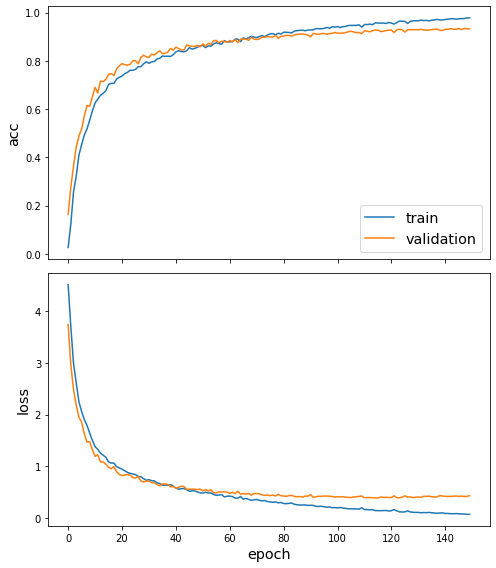

In [16]:
sg.utils.plot_history(history)

## Testing

In [17]:
# use the model to predict on testing data and get predicted labels
pred_prob = model.predict(test_gen)
pred_labels = np.argmax(pred_prob, axis=-1) 
pred_labels = [str(x+1) for x in list(pred_labels)]

# get the true labels of the testing data
test_labels = np.argmax(test_graph_labels.values, axis=-1)
test_labels = [str(x+1) for x in list(test_labels)]

# show the result as classification report
print(classification_report(test_labels, pred_labels, target_names=apps, digits=4))

                          precision    recall  f1-score   support

                  diijam     0.9345    0.9874    0.9602       159
                  baomoi     0.9218    0.9429    0.9322       175
                 fptplay     0.9614    0.9614    0.9614       259
                   iQIYI     0.9755    0.9464    0.9607       168
                    bigo     0.9171    0.9672    0.9415       183
                 myradio     0.9559    0.9220    0.9386       141
                 spotify     0.9265    0.9130    0.9197       138
              nhaccuatui     0.9532    0.8956    0.9235       182
              soundcloud     0.9458    0.8486    0.8946       185
              sachnoiapp     0.9252    0.9340    0.9296       106
                 phim247     0.9536    0.9231    0.9381       156
                 popskid     0.9479    0.9630    0.9554       189
  truyenaudiosachnoiviet     0.9910    0.9565    0.9735       115
                   vieon     0.8369    0.8939    0.8645       132
         

-------------------------------------------------------------